# Download the dataset

In [ ]:
from google.colab import files
import os
files.upload()  # kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"worldmansist15","key":"58a9df1a79834b926c0f4a00861dd558"}'}

In [ ]:
!pip install -q kaggle

os.makedirs("/root/.kaggle", exist_ok=True)
if os.path.exists("kaggle.json"):
    os.replace("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
# 1. Kaggle Download & Unzip (automatisch)
import os

DATA_DIR = "/content/datasciencebowl"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# Kaggle API: Dataset herunterladen
if not os.path.exists("datasciencebowl.zip"):
    !kaggle competitions download -c datasciencebowl --quiet

# Hauptzip entpacken
if not os.path.exists(DATA_DIR):
    !unzip -q datasciencebowl.zip -d datasciencebowl

# Train, Test, SampleSubmission entpacken
!unzip -oq datasciencebowl/train.zip -d datasciencebowl/train
!unzip -oq datasciencebowl/test.zip -d datasciencebowl/test
!unzip -oq datasciencebowl/sampleSubmission.csv.zip -d datasciencebowl

# Doppelten train-Ordner zusammenführen (rsync)
if os.path.exists("datasciencebowl/train/train"):
    !rsync -a --ignore-existing datasciencebowl/train/train/ datasciencebowl/train/
    !rm -r datasciencebowl/train/train

print("Done!")



Done!


In [ ]:
# Checking
DATA_DIR = "/content/datasciencebowl"
print("Train classes:", len(os.listdir(f"{DATA_DIR}/train")))
print("Test :",  len(os.listdir(f"{DATA_DIR}/test")))

Train classes: 121
Test : 1


# Work with classes

In [ ]:
import pandas as pd
from PIL import Image
from collections import Counter

DATA_DIR = "/content/datasciencebowl"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

In [ ]:
classes = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

n_classes = len(classes)

print(f"Number of classes: {n_classes}")
print("First 10 classes:", classes[:10])

Number of classes: 121
First 10 classes: ['acantharia_protist', 'acantharia_protist_big_center', 'acantharia_protist_halo', 'amphipods', 'appendicularian_fritillaridae', 'appendicularian_s_shape', 'appendicularian_slight_curve', 'appendicularian_straight', 'artifacts', 'artifacts_edge']


In [ ]:
class_counts = {}

for cls in classes:
    cls_path = os.path.join(TRAIN_DIR, cls)
    class_counts[cls] = len([
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

df_counts = (
    pd.DataFrame.from_dict(class_counts, orient="index", columns=["num_images"])
    .sort_values("num_images", ascending=False)
)

df_counts

,num_images
trichodesmium_puff,1979
chaetognath_other,1934
copepod_cyclopoid_oithona_eggs,1189
protist_other,1172
detritus_other,914
...,...
pteropod_theco_dev_seq,13
hydromedusae_other,12
fish_larvae_deep_body,10
heteropod,10


In [ ]:
df_counts.describe()

,num_images
count,121.000000
mean,250.710744
std,338.852216
min,9.000000
25%,49.000000
50%,114.000000
75%,352.000000
max,1979.000000


In [ ]:
threshold = 0

df_counts_filtered = df_counts[df_counts["num_images"] > threshold]

print(f"Classes with more than {threshold} images: {len(df_counts_filtered)}")

Classes with more than 0 images: 121


In [ ]:
classes_filtered = df_counts_filtered.index.tolist()
n_classes_filtered = len(classes_filtered)

# Sizes

In [ ]:
sizes = []

for cls in classes_filtered:
    cls_path = os.path.join(TRAIN_DIR, cls)

    for fname in os.listdir(cls_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(cls_path, fname)
            try:
                with Image.open(img_path) as img:
                    sizes.append(img.size)  # (width, height)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

df_sizes = pd.DataFrame(sizes, columns=["width", "height"])
df_sizes.describe()

,width,height
count,30336.000000,30336.000000
mean,73.507285,66.661821
std,49.162891,43.460964
min,31.000000,21.000000
25%,44.000000,43.000000
50%,56.000000,53.000000
75%,83.000000,72.000000
max,424.000000,428.000000


# PyTorch Dataset

In [ ]:
# 2. Imports
import copy
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
from torch.utils.data import Dataset

# 3. Custom dataset
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, classes=None, transform=None):
        self.samples = []
        if classes is None:
            classes = sorted([
                d for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
            ])
        self.label2idx = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            for f in os.listdir(cls_path):
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append((cls, os.path.join(cls_path, f)))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label, path = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label2idx[label]

In [ ]:
# 4. Filter Classes by Threshold
classes = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

class_counts = {
    cls: len([
        f for f in os.listdir(os.path.join(TRAIN_DIR, cls))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])
    for cls in classes
}

df_counts = pd.DataFrame.from_dict(class_counts, orient="index", columns=["num_images"])
df_counts = df_counts.sort_values("num_images", ascending=False)

threshold = 49
classes_filtered = df_counts[df_counts["num_images"] > threshold].index.tolist()
print(f"Filtered classes: {len(classes_filtered)}")

Filtered classes: 88


In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

pixel_sum = np.zeros(3)
pixel_sq_sum = np.zeros(3)
pixel_count = 0

for cls in tqdm(classes_filtered):
    cls_dir = os.path.join(TRAIN_DIR, cls)

    for f in os.listdir(cls_dir):
        img = np.array(
            Image.open(os.path.join(cls_dir, f)).convert("RGB"),
            dtype=np.float32
        )

        # shape: H x W x 3
        pixel_sum += img.sum(axis=(0, 1))
        pixel_sq_sum += (img ** 2).sum(axis=(0, 1))
        pixel_count += img.shape[0] * img.shape[1]

# mean / std per channel
global_mean = pixel_sum / pixel_count
global_std = np.sqrt(pixel_sq_sum / pixel_count - global_mean ** 2)

print("Global mean:", global_mean)
print("Global std:", global_std)



# global_mean = [mR, mG, mB]
# global_std  = [sR, sG, sB]

100%|██████████| 88/88 [00:13<00:00,  6.45it/s]

Global mean: [241.03449992 241.03449992 241.03449992]
Global std: [40.78570893 40.78570893 40.78570893]


In [ ]:
# @title
# # 5. Compute global mean and std
# pixel_sum, pixel_sq_sum, pixel_count = 0, 0, 0
# for cls in tqdm(classes_filtered, desc="Calculating mean/std"):
#     cls_path = os.path.join(TRAIN_DIR, cls)
#     for f in os.listdir(cls_path):
#         if f.lower().endswith((".png", ".jpg", ".jpeg")):
#             img = np.array(Image.open(os.path.join(cls_path, f)).convert("RGB"), dtype=np.float32)
#             pixel_sum += img.sum()
#             pixel_sq_sum += (img ** 2).sum()
#             pixel_count += img.size

# global_mean = pixel_sum / pixel_count
# global_std = np.sqrt(pixel_sq_sum / pixel_count - global_mean**2)
# print(f"Global mean: {global_mean:.2f}, Global std: {global_std:.2f}")

# mean = global_mean / 255.0
# std  = global_std / 255.0

# Transformations and augmentations

#### Based on dataset statistics (median ≈ 55×52, 75th percentile ≈ 80×70)

In [ ]:
from torchvision import transforms

GLOBAL_MEAN = (global_mean / 255.0).tolist()
GLOBAL_STD  = (global_std  / 255.0).tolist()

train_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(GLOBAL_MEAN, GLOBAL_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(GLOBAL_MEAN, GLOBAL_STD)
])

In [ ]:
# 7. Dataset (без transform, только для split)
base_dataset = ImageFolderDataset(
    root_dir=TRAIN_DIR,
    classes=classes_filtered
)

labels = [base_dataset.label2idx[label] for label, _ in base_dataset.samples]
indices = list(range(len(base_dataset)))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# 🔹 отдельные датасеты с разными transform
train_dataset = ImageFolderDataset(
    root_dir=TRAIN_DIR,
    classes=classes_filtered,
    transform=train_transform
)

val_dataset = ImageFolderDataset(
    root_dir=TRAIN_DIR,
    classes=classes_filtered,
    transform=val_transform
)

train_ds = Subset(train_dataset, train_idx)
val_ds   = Subset(val_dataset, val_idx)

In [ ]:
from torch.utils.data import DataLoader

# 8. DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# EfficientNet_B1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

In [ ]:
# @title
# # @title
# # 9. Model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes_filtered))
# model.to(device)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    len(classes_filtered)
)
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth


100%|██████████| 30.1M/30.1M [00:00<00:00, 131MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# @title
# for param in model.features.parameters():
#     param.requires_grad = False

# for param in model.classifier.parameters():
#     param.requires_grad = True

In [ ]:
import numpy as np
import torch
from collections import Counter

# ===== GET TRAIN LABELS FROM Subset =====
train_labels = [
    train_ds.dataset.label2idx[
        train_ds.dataset.samples[i][0]
    ]
    for i in train_ds.indices
]

train_labels = np.array(train_labels)

# ===== CLASS COUNTS =====
class_counts = np.bincount(train_labels)
num_classes = len(class_counts)

print("Class counts:", class_counts)

# ===== CLASS WEIGHTS (inverse frequency) =====
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * num_classes

class_weights = torch.tensor(
    class_weights,
    dtype=torch.float32,
    device=device
)

print("Class weights:", class_weights)

Class counts: [1583 1547  951  938  731  719  711  652  566  562  557  555  545  542
  500  429  426  415  409  400  386  351  340  334  330  315  314  308
  298  290  282  269  254  230  229  219  198  194  189  183  170  161
  152  143  142  140  139  138  136  126  122  120  113  109  108  106
  105  102  102   98   91   90   90   86   86   85   77   77   74   70
   70   68   64   62   61   60   58   57   52   51   50   49   46   45
   44   43   42   42]
Class weights: tensor([0.0751, 0.0769, 0.1251, 0.1268, 0.1627, 0.1654, 0.1673, 0.1824, 0.2102,
        0.2117, 0.2136, 0.2143, 0.2183, 0.2195, 0.2379, 0.2773, 0.2792, 0.2866,
        0.2908, 0.2974, 0.3082, 0.3389, 0.3499, 0.3562, 0.3605, 0.3776, 0.3788,
        0.3862, 0.3992, 0.4102, 0.4218, 0.4422, 0.4683, 0.5172, 0.5195, 0.5432,
        0.6008, 0.6132, 0.6294, 0.6500, 0.6997, 0.7388, 0.7826, 0.8319, 0.8377,
        0.8497, 0.8558, 0.8620, 0.8747, 0.9441, 0.9750, 0.9913, 1.0527, 1.0913,
        1.1014, 1.1222, 1.1329, 1.1662, 1.1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(
        self,
        alpha=None,
        gamma=2.0,
        label_smoothing=0.0,
        reduction="mean"
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, logits, targets):
        num_classes = logits.size(1)

        # ---- one-hot with label smoothing ----
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.label_smoothing / (num_classes - 1))
            true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - self.label_smoothing)

        log_probs = F.log_softmax(logits, dim=1)
        probs = log_probs.exp()

        # ---- focal weight ----
        pt = (probs * true_dist).sum(dim=1)
        focal_weight = (1 - pt) ** self.gamma

        # ---- cross-entropy with smoothed labels ----
        ce_loss = -(true_dist * log_probs).sum(dim=1)

        # ---- class weights ----
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            ce_loss = ce_loss * alpha_t

        loss = focal_weight * ce_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

In [ ]:
# @title
## 3 types of losses

# criterion = FocalLoss(
#     alpha=class_weights,
#     gamma=1.5,  # можно потом попробовать 2.0
# )

#criterion = nn.CrossEntropyLoss(weight=class_weights)

# criterion = nn.CrossEntropyLoss()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


criterion = FocalLoss(
    alpha=class_weights,
    gamma=1,  # можно потом попробовать 2.0
)



# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

In [ ]:
epochs = 30
patience = 5

train_losses, val_losses, val_f1_scores = [], [], []
best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # ===== TRAIN =====
    model.train()
    running_train_loss = 0.0

    train_pbar = tqdm(train_loader, desc="Train", leave=False)

    for x, y in train_pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ===== VALIDATION =====
    model.eval()
    running_val_loss = 0.0
    all_preds, all_labels = [], []

    val_pbar = tqdm(val_loader, desc="Val", leave=False)

    with torch.no_grad():
        for x, y in val_pbar:
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            running_val_loss += loss.item()

            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            val_pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1_scores.append(val_f1)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Macro-F1: {val_f1:.4f}"
    )

    # ===== SCHEDULER STEP =====
    scheduler.step(epoch + 1)

    # ===== EARLY STOPPING =====
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_wts)


Epoch 1/30


Epoch 1/30 | Train Loss: 0.4580 | Val Loss: 0.3578 | Val Macro-F1: 0.6395

Epoch 2/30


Epoch 2/30 | Train Loss: 0.3345 | Val Loss: 0.3149 | Val Macro-F1: 0.6692

Epoch 3/30


Epoch 3/30 | Train Loss: 0.2631 | Val Loss: 0.3055 | Val Macro-F1: 0.6815

Epoch 4/30


Epoch 4/30 | Train Loss: 0.2170 | Val Loss: 0.3005 | Val Macro-F1: 0.6977

Epoch 5/30


Epoch 5/30 | Train Loss: 0.1820 | Val Loss: 0.2923 | Val Macro-F1: 0.7042

Epoch 6/30


Epoch 6/30 | Train Loss: 0.1548 | Val Loss: 0.2965 | Val Macro-F1: 0.7085

Epoch 7/30


Epoch 7/30 | Train Loss: 0.1329 | Val Loss: 0.3020 | Val Macro-F1: 0.7031

Epoch 8/30


Epoch 8/30 | Train Loss: 0.1138 | Val Loss: 0.3114 | Val Macro-F1: 0.7169

Epoch 9/30


Epoch 9/30 | Train Loss: 0.1026 | Val Loss: 0.3124 | Val Macro-F1: 0.7182

Epoch 10/30


Epoch 10/30 | Train Loss: 0.0882 | Val Loss: 0.3263 | Val Macro-F1: 0.7129

Epoch 11/30


Epoch 11/30 | Train Loss: 0.0815 | Val Loss: 0.3405 | Val Macro-F1: 0.7178

Epoch 12/30


Epoch 12/30 | Train Loss: 0.0703 | Val Loss: 0.3328 | Val Macro-F1: 0.7205

Epoch 13/30


Epoch 13/30 | Train Loss: 0.0613 | Val Loss: 0.3424 | Val Macro-F1: 0.7220

Epoch 14/30


Epoch 14/30 | Train Loss: 0.0574 | Val Loss: 0.3570 | Val Macro-F1: 0.7099

Epoch 15/30


Epoch 15/30 | Train Loss: 0.0526 | Val Loss: 0.3565 | Val Macro-F1: 0.7201

Epoch 16/30


Epoch 16/30 | Train Loss: 0.0476 | Val Loss: 0.3638 | Val Macro-F1: 0.7239

Epoch 17/30


Epoch 17/30 | Train Loss: 0.0445 | Val Loss: 0.3872 | Val Macro-F1: 0.7106

Epoch 18/30


Epoch 18/30 | Train Loss: 0.0395 | Val Loss: 0.3745 | Val Macro-F1: 0.7247

Epoch 19/30


Epoch 19/30 | Train Loss: 0.0377 | Val Loss: 0.3889 | Val Macro-F1: 0.7177

Epoch 20/30


Epoch 20/30 | Train Loss: 0.0342 | Val Loss: 0.4129 | Val Macro-F1: 0.7157

Epoch 21/30


Epoch 21/30 | Train Loss: 0.0301 | Val Loss: 0.4105 | Val Macro-F1: 0.7126

Epoch 22/30


Epoch 22/30 | Train Loss: 0.0347 | Val Loss: 0.4095 | Val Macro-F1: 0.7192

Epoch 23/30


Epoch 23/30 | Train Loss: 0.0313 | Val Loss: 0.4055 | Val Macro-F1: 0.7141
Early stopping triggered at epoch 23


<All keys matched successfully>

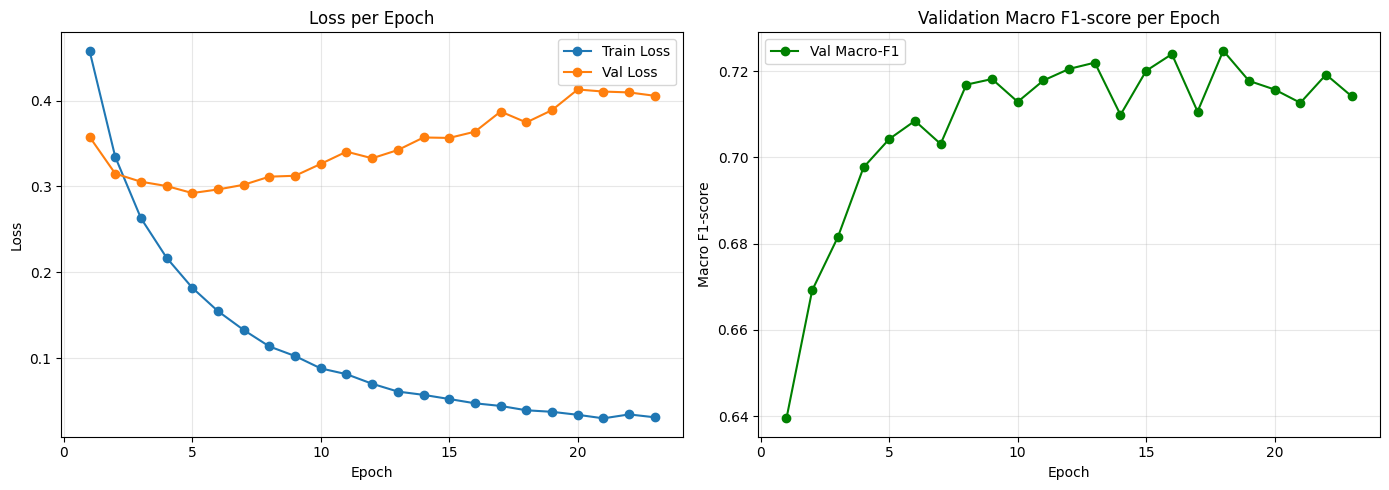

In [ ]:
import matplotlib.pyplot as plt

# оси X под каждую метрику
epochs_loss = range(1, len(train_losses) + 1)
epochs_f1   = range(1, len(val_f1_scores) + 1)

plt.figure(figsize=(14, 5))

# ===== LOSS =====
plt.subplot(1, 2, 1)
plt.plot(epochs_loss, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_loss, val_losses, marker='o', label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

# ===== MACRO F1 =====
plt.subplot(1, 2, 2)
plt.plot(
    epochs_f1,
    val_f1_scores,
    marker='o',
    color='green',
    label='Val Macro-F1'
)
plt.title("Validation Macro F1-score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Macro F1-score")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Confusion matrix"):
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        preds = out.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

Confusion matrix: 100%|██████████| 185/185 [00:06<00:00, 28.42it/s]


# confusion matrix

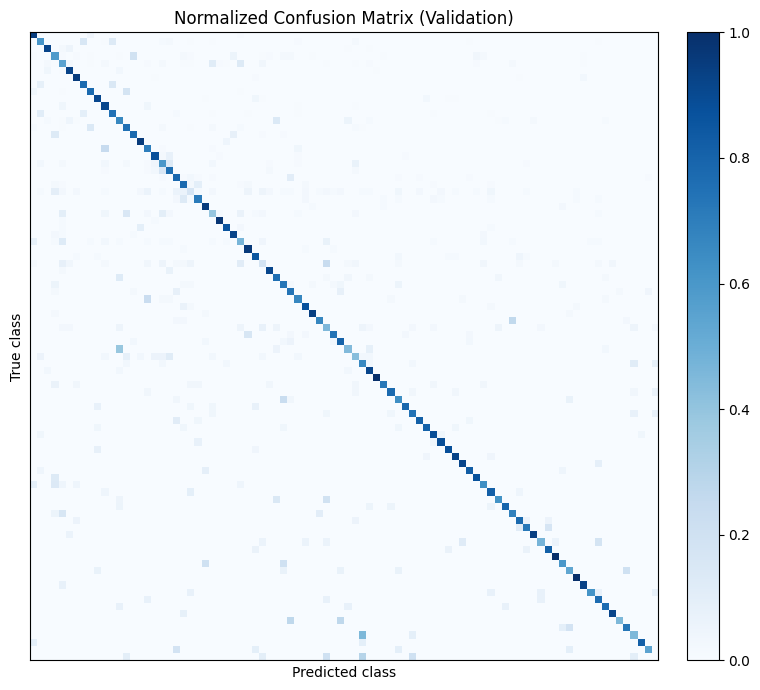

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# считаем confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# нормализация по истинным классам
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 7))
im = plt.imshow(cm_norm, cmap="Blues", interpolation="nearest")

plt.colorbar(im, fraction=0.046, pad=0.04)

plt.title("Normalized Confusion Matrix (Validation)")
plt.xlabel("Predicted class")
plt.ylabel("True class")

# ❌ убираем подписи осей
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig("confusion_matrix_all_classes.png", dpi=300)
plt.show()

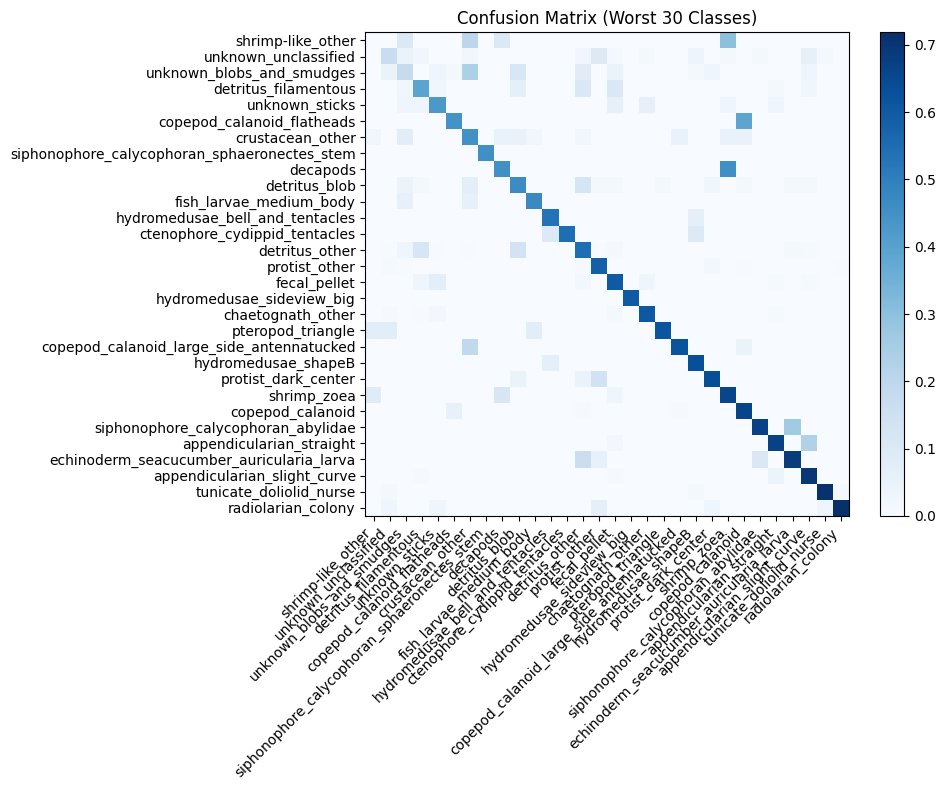

In [ ]:
# accuracy per class (диагональ)
class_acc = np.diag(cm_norm)

# берём 20 классов с худшей точностью
K = 30
worst_idx = np.argsort(class_acc)[:K]

cm_small = cm_norm[np.ix_(worst_idx, worst_idx)]
class_names_small = [classes_filtered[i] for i in worst_idx]

plt.figure(figsize=(10, 8))
im = plt.imshow(cm_small, cmap="Blues")
plt.colorbar(im)

plt.xticks(range(K), class_names_small, rotation=45, ha="right")
plt.yticks(range(K), class_names_small)

plt.title("Confusion Matrix (Worst 30 Classes)")
plt.tight_layout()
plt.savefig("confusion_matrix_top30.png", dpi=300)
plt.show()

# describing number of data in validation sets

In [ ]:
import numpy as np

# all_labels уже есть из val_loader
unique, counts = np.unique(all_labels, return_counts=True)

val_class_counts = dict(zip(unique, counts))

print("Validation samples per class:\n")
for idx in worst_idx:
    cls = classes_filtered[idx]
    cnt = val_class_counts.get(idx, 0)
    print(f"{cls:35s} {cnt}")

Validation samples per class:

shrimp-like_other                   10
unknown_unclassified                85
unknown_blobs_and_smudges           63
detritus_filamentous                79
unknown_sticks                      35
copepod_calanoid_flatheads          36
crustacean_other                    40
siphonophore_calycophoran_sphaeronectes_stem 11
decapods                            11
detritus_blob                       73
fish_larvae_medium_body             17
hydromedusae_bell_and_tentacles     15
ctenophore_cydippid_tentacles       11
detritus_other                      183
protist_other                       234
fecal_pellet                        102
hydromedusae_sideview_big           15
chaetognath_other                   387
pteropod_triangle                   13
copepod_calanoid_large_side_antennatucked 21
hydromedusae_shapeB                 30
protist_dark_center                 22
shrimp_zoea                         35
copepod_calanoid                    136
siphonophore_

In [ ]:
import pandas as pd
import numpy as np

# counts по validation
unique, counts = np.unique(all_labels, return_counts=True)
val_class_counts = dict(zip(unique, counts))

rows = []

for idx in worst_idx:
    idx = int(idx)  # защита от float
    cls = classes_filtered[idx]
    cnt = val_class_counts.get(idx, 0)
    rows.append({
        "class": cls,
        "val_samples": cnt
    })

df_worst = pd.DataFrame(rows)

# сортировка по числу изображений (по желанию)
df_worst = df_worst.sort_values("val_samples")

df_worst

,class,val_samples
0,shrimp-like_other,10
7,siphonophore_calycophoran_sphaeronectes_stem,11
12,ctenophore_cydippid_tentacles,11
8,decapods,11
18,pteropod_triangle,13
11,hydromedusae_bell_and_tentacles,15
16,hydromedusae_sideview_big,15
10,fish_larvae_medium_body,17
26,echinoderm_seacucumber_auricularia_larva,19
19,copepod_calanoid_large_side_antennatucked,21


In [ ]:
# @title
# import os

# class_counts = {}

# for cls in classes_filtered:
#     cls_dir = os.path.join(TRAIN_DIR, cls)
#     class_counts[cls] = len([
#         f for f in os.listdir(cls_dir)
#         if os.path.isfile(os.path.join(cls_dir, f))
#     ])

# # вывести
# for cls, cnt in sorted(class_counts.items(), key=lambda x: x[1]):
#     print(f"{cls:35s} {cnt}")

# Exploring the errors in the most confusing pairs of classes

In [ ]:
errors = []

for i in range(len(classes_filtered)):
    for j in range(len(classes_filtered)):
        if i != j and cm_norm[i, j] > 0.05:  # порог
            errors.append((cm_norm[i, j], classes_filtered[i], classes_filtered[j]))

errors = sorted(errors, reverse=True)[:20]

print("Top confusing pairs:")
for val, true_cls, pred_cls in errors:
    print(f"{true_cls} → {pred_cls}: {val:.2f}")

Top confusing pairs:
decapods → shrimp_zoea: 0.45
copepod_calanoid_flatheads → copepod_calanoid: 0.39
shrimp-like_other → shrimp_zoea: 0.30
siphonophore_calycophoran_sphaeronectes_stem → siphonophore_calycophoran_sphaeronectes_young: 0.27
siphonophore_calycophoran_sphaeronectes_stem → siphonophore_calycophoran_sphaeronectes: 0.27
siphonophore_calycophoran_abylidae → echinoderm_seacucumber_auricularia_larva: 0.26
appendicularian_slight_curve → appendicularian_s_shape: 0.25
unknown_blobs_and_smudges → crustacean_other: 0.24
hydromedusae_shapeB → hydromedusae_shapeA_sideview_small: 0.23
appendicularian_straight → appendicularian_slight_curve: 0.23
shrimp-like_other → euphausiids: 0.20
shrimp-like_other → crustacean_other: 0.20
hydromedusae_sideview_big → hydromedusae_shapeA_sideview_small: 0.20
hydromedusae_sideview_big → hydromedusae_shapeA: 0.20
hydromedusae_bell_and_tentacles → hydromedusae_typeD_bell_and_tentacles: 0.20
copepod_calanoid_large_side_antennatucked → crustacean_other: 0.1

In [ ]:
errors = []

for i in range(len(classes_filtered)):
    for j in range(len(classes_filtered)):
        if i != j:
            errors.append((cm_norm[i, j], classes_filtered[i], classes_filtered[j]))

errors_sorted = sorted(errors, reverse=True)[:5]

print("Top confusing class pairs:")
for val, true_cls, pred_cls in errors_sorted:
    print(f"{true_cls} → {pred_cls}: {val:.2f}")

Top confusing class pairs:
decapods → shrimp_zoea: 0.45
copepod_calanoid_flatheads → copepod_calanoid: 0.39
shrimp-like_other → shrimp_zoea: 0.30
siphonophore_calycophoran_sphaeronectes_stem → siphonophore_calycophoran_sphaeronectes_young: 0.27
siphonophore_calycophoran_sphaeronectes_stem → siphonophore_calycophoran_sphaeronectes: 0.27


#EfficientNet_B1 with unfreezing

In [ ]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import (
    efficientnet_b1,
    EfficientNet_B1_Weights
)
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# ================= DEVICE =================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ================= MODEL =================
model = efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)

model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    len(classes_filtered)
)

model.to(device)

In [ ]:
# ================= FREEZE BACKBONE =================
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
# ================= LOSS & OPTIMIZER (STAGE 1) =================
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-3
)

In [ ]:
# ================= TRAINING PARAMS =================
epochs = 30
unfreeze_epoch = 8        # 🔥 epoch, когда начинаем fine-tuning
patience = 5

train_losses = []
val_losses = []
val_f1_scores = []

best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0


# ================= TRAIN LOOP =================
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # 🔥 UNFREEZE
    if epoch == unfreeze_epoch:
        print("🔥 Unfreezing EfficientNet backbone")

        for param in model.features.parameters():
            param.requires_grad = True

        optimizer = optim.Adam(
            model.parameters(),
            lr=1e-4   # lower LR for fine-tuning
        )

    # ===== TRAIN =====
    model.train()
    running_train_loss = 0.0

    train_pbar = tqdm(train_loader, desc="Train", leave=False)
    for x, y in train_pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ===== VALIDATION =====
    model.eval()
    running_val_loss = 0.0
    all_preds, all_labels = [], []

    val_pbar = tqdm(val_loader, desc="Val", leave=False)
    with torch.no_grad():
        for x, y in val_pbar:
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            running_val_loss += loss.item()

            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            val_pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1_scores.append(val_f1)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Macro-F1: {val_f1:.4f}"
    )

    # ===== EARLY STOPPING =====
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}")
            break


# ================= LOAD BEST MODEL =================
model.load_state_dict(best_model_wts)
print(f"✅ Best validation Macro-F1: {best_f1:.4f}")


Epoch 1/30


Epoch 1/30 | Train Loss: 2.4728 | Val Loss: 1.7397 | Val Macro-F1: 0.3561

Epoch 2/30


Epoch 2/30 | Train Loss: 1.6999 | Val Loss: 1.5206 | Val Macro-F1: 0.4480

Epoch 3/30


Epoch 3/30 | Train Loss: 1.5060 | Val Loss: 1.4183 | Val Macro-F1: 0.4887

Epoch 4/30


Epoch 4/30 | Train Loss: 1.4114 | Val Loss: 1.3637 | Val Macro-F1: 0.5033

Epoch 5/30


Epoch 5/30 | Train Loss: 1.3571 | Val Loss: 1.4522 | Val Macro-F1: 0.5172

Epoch 6/30


Epoch 6/30 | Train Loss: 1.3154 | Val Loss: 1.4310 | Val Macro-F1: 0.5158

Epoch 7/30


Epoch 7/30 | Train Loss: 1.2801 | Val Loss: 1.2832 | Val Macro-F1: 0.5413

Epoch 8/30


Epoch 8/30 | Train Loss: 1.2567 | Val Loss: 1.3012 | Val Macro-F1: 0.5378

Epoch 9/30
🔥 Unfreezing EfficientNet backbone


Epoch 9/30 | Train Loss: 1.0140 | Val Loss: 0.9442 | Val Macro-F1: 0.6506

Epoch 10/30


Epoch 10/30 | Train Loss: 0.7860 | Val Loss: 0.8916 | Val Macro-F1: 0.6659

Epoch 11/30


Epoch 11/30 | Train Loss: 0.6447 | Val Loss: 0.8399 | Val Macro-F1: 0.6905

Epoch 12/30


Epoch 12/30 | Train Loss: 0.5439 | Val Loss: 0.8405 | Val Macro-F1: 0.6936

Epoch 13/30


Epoch 13/30 | Train Loss: 0.4648 | Val Loss: 0.8541 | Val Macro-F1: 0.6856

Epoch 14/30


Epoch 14/30 | Train Loss: 0.3943 | Val Loss: 0.8628 | Val Macro-F1: 0.6875

Epoch 15/30


Epoch 15/30 | Train Loss: 0.3305 | Val Loss: 0.8898 | Val Macro-F1: 0.6909

Epoch 16/30


Epoch 16/30 | Train Loss: 0.2824 | Val Loss: 0.8942 | Val Macro-F1: 0.6936

Epoch 17/30


Epoch 17/30 | Train Loss: 0.2420 | Val Loss: 0.9256 | Val Macro-F1: 0.6987

Epoch 18/30


Epoch 18/30 | Train Loss: 0.2068 | Val Loss: 0.9353 | Val Macro-F1: 0.6961

Epoch 19/30


Epoch 19/30 | Train Loss: 0.1787 | Val Loss: 0.9766 | Val Macro-F1: 0.6965

Epoch 20/30


Epoch 20/30 | Train Loss: 0.1566 | Val Loss: 0.9951 | Val Macro-F1: 0.7005

Epoch 21/30


Epoch 21/30 | Train Loss: 0.1364 | Val Loss: 1.0359 | Val Macro-F1: 0.6919

Epoch 22/30


Epoch 22/30 | Train Loss: 0.1241 | Val Loss: 1.0388 | Val Macro-F1: 0.6918

Epoch 23/30


Epoch 23/30 | Train Loss: 0.1131 | Val Loss: 1.0626 | Val Macro-F1: 0.6944

Epoch 24/30


Epoch 24/30 | Train Loss: 0.1019 | Val Loss: 1.0871 | Val Macro-F1: 0.6914

Epoch 25/30


Epoch 25/30 | Train Loss: 0.0961 | Val Loss: 1.0997 | Val Macro-F1: 0.6944
🛑 Early stopping triggered at epoch 25
✅ Best validation Macro-F1: 0.7005


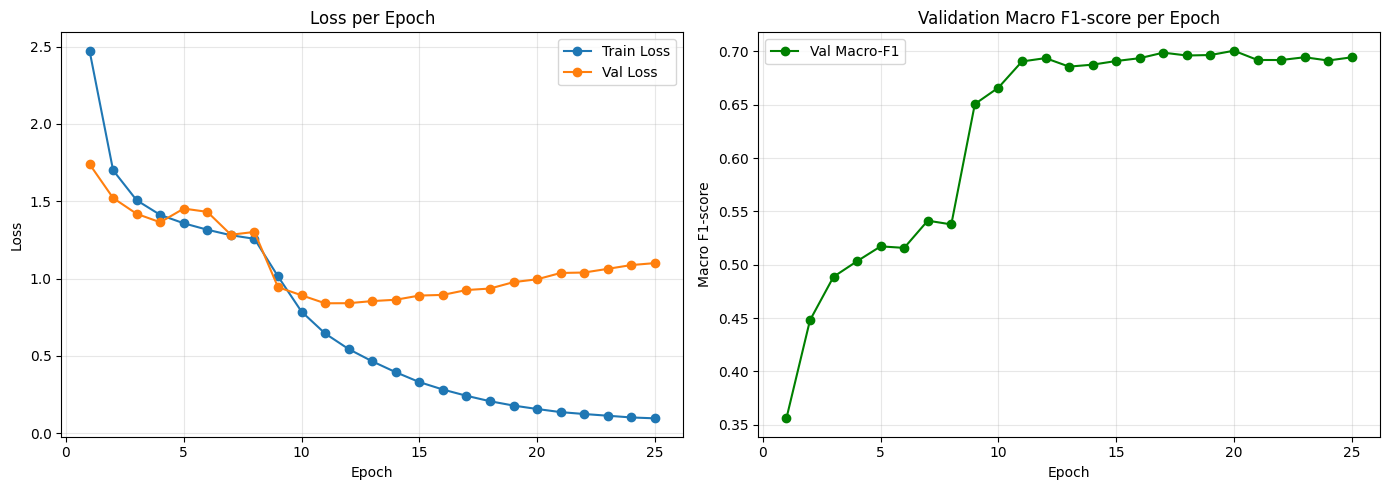

In [ ]:
import matplotlib.pyplot as plt

# оси X под каждую метрику
epochs_loss = range(1, len(train_losses) + 1)
epochs_f1   = range(1, len(val_f1_scores) + 1)

plt.figure(figsize=(14, 5))

# ===== LOSS =====
plt.subplot(1, 2, 1)
plt.plot(epochs_loss, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_loss, val_losses, marker='o', label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

# ===== MACRO F1 =====
plt.subplot(1, 2, 2)
plt.plot(
    epochs_f1,
    val_f1_scores,
    marker='o',
    color='green',
    label='Val Macro-F1'
)
plt.title("Validation Macro F1-score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Macro F1-score")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Confusion matrix"):
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        preds = out.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

Confusion matrix: 100%|██████████| 185/185 [00:12<00:00, 15.11it/s]


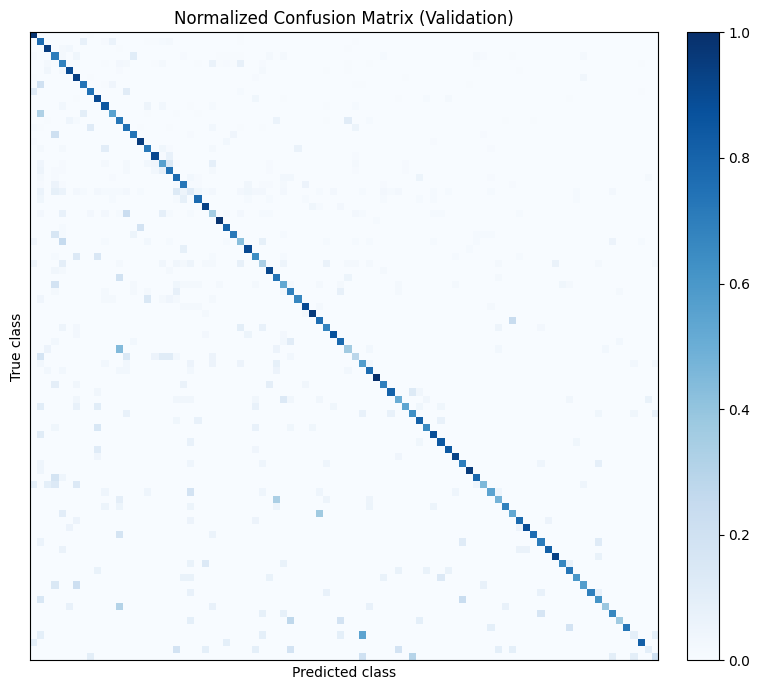

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# считаем confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# нормализация по истинным классам
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 7))
im = plt.imshow(cm_norm, cmap="Blues", interpolation="nearest")

plt.colorbar(im, fraction=0.046, pad=0.04)

plt.title("Normalized Confusion Matrix (Validation)")
plt.xlabel("Predicted class")
plt.ylabel("True class")

# ❌ убираем подписи осей
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig("confusion_matrix_all_classes.png", dpi=300)
plt.show()

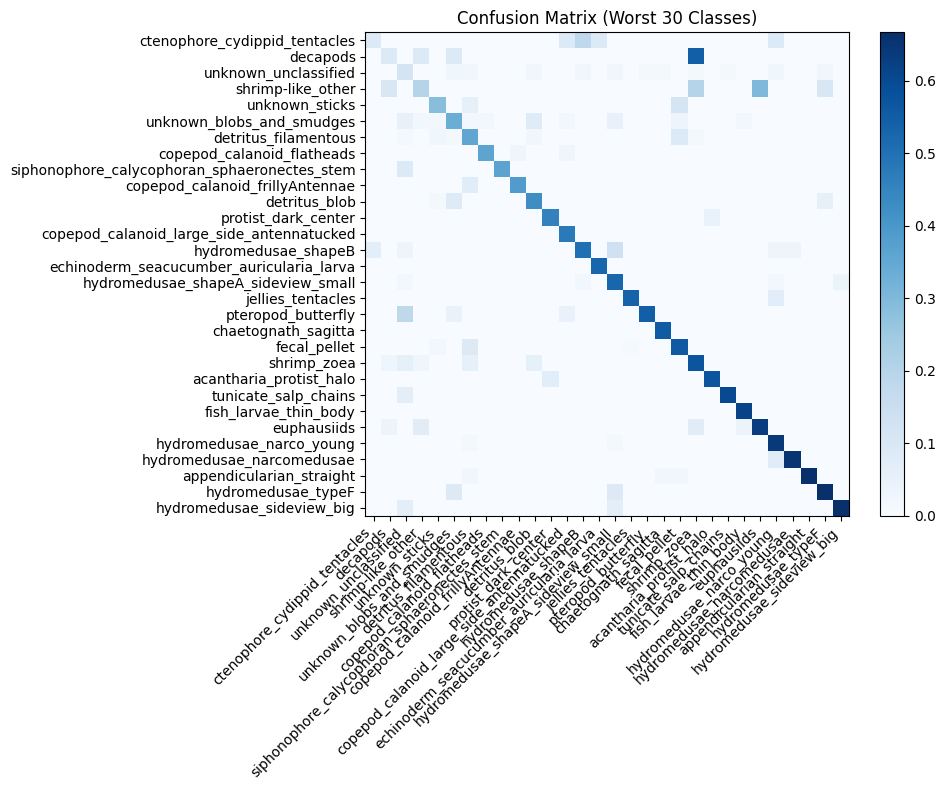

In [ ]:
# accuracy per class (диагональ)
class_acc = np.diag(cm_norm)

# берём 20 классов с худшей точностью
K = 30
worst_idx = np.argsort(class_acc)[:K]

cm_small = cm_norm[np.ix_(worst_idx, worst_idx)]
class_names_small = [classes_filtered[i] for i in worst_idx]

plt.figure(figsize=(10, 8))
im = plt.imshow(cm_small, cmap="Blues")
plt.colorbar(im)

plt.xticks(range(K), class_names_small, rotation=45, ha="right")
plt.yticks(range(K), class_names_small)

plt.title("Confusion Matrix (Worst 30 Classes)")
plt.tight_layout()
plt.savefig("confusion_matrix_top30.png", dpi=300)
plt.show()